# Cognitive, behavioral and social data
**Author**: Mattia Brocco

MERGE OF DATASETS FOR **R_NEO_PI**
```python
a = pd.read_excel(data_dir + "\\R_NEO_PI_Faked.xlsx")
b = pd.read_excel(data_dir + "\\R_NEO_PI_Honest.xlsx")

a.columns = [" ".join([pd.Series(a.columns).apply(lambda s: np.nan if "Unnamed"
                                                  in s else s).fillna(method = "ffill").tolist()[i],
                       a.loc[0][i]]) for i in range(len(a.columns))]
b.columns = [" ".join([pd.Series(b.columns).apply(lambda s: np.nan if "Unnamed"
                                                  in s else s).fillna(method = "ffill").tolist()[i],
                       b.loc[0][i]]) for i in range(len(b.columns))]

a = a.drop(0).reset_index(drop = True)
b = b.drop(0).reset_index(drop = True)

a["CONDITION"] = "FAKE"
b["CONDITION"] = "HONEST"

pd.concat([a, b], ignore_index = True).to_excel(data_dir + "\\R_NEO_PI.xlsx", index = False)
```

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


import support
from engine import Classification

%load_ext autoreload
%autoreload 2

data_dir = ".\\data"

pd.options.display.max_columns = 500

### Datasets at hand

In [2]:
data_descr = pd.DataFrame(dict(zip([f for f in os.listdir(data_dir) if "parquet" in f],
                                   [pd.read_parquet(f"{data_dir}\\{f}").shape for f in os.listdir(data_dir)
                                    if "parquet" in f]))).T.reset_index()
data_descr = data_descr.rename(columns = {"index": "Data", 0: "Sample size",
                                          1: "Features"})
data_descr

,Data,Sample size,Features
0,BF_df_CTU.parquet,442,11
1,BF_df_OU.parquet,460,11
2,BF_df_V.parquet,486,11
3,DT_df_CC.parquet,482,28
4,DT_df_JI.parquet,864,28
5,IADQ_df.parquet,450,10
6,IESR_df.parquet,358,23
7,NAQ_R_df.parquet,712,23
8,PCL5_df.parquet,402,21
9,PHQ9_GAD7_df.parquet,1118,17


## Design a pipeline
***

The goal is to find a stable subset of features across datasets that performs roughly the same across different classifiers. Accoringly, we can define a "good" feature selection procedure, one that does not depend on a specific model, but that allows models to perform roughly the same, and for all the datasets within the scope.

##### DESCRIPTION
1. A given dataset is split in training and test. For every feature, the mean and the standard deviation are computed in order to scale that feauture: $Z=\frac{X-\mu}{\sigma}$. Scaling on the test set is carried out using the same values computed for training data.
2. The actual phase of the selection of a subset of features occurs through a 3-step process:  
    * Train a Decision Tree and apply minimal cost-complexity pruning. <sup>[1]</sup>  
    * Train a Random Forest that expolits gradient boosting <sup>[2]</sup>, in which each tree retains the cost-complexity parameter obtained in the previous step.  
    * Compute permutation importance on this Random Forest <sup>[3]</sup>.  
    * Perform a one-sample test on the mean, given the distribution obtained for each feature importance (with confidence level at 99.999%). This way only features whose importance is significantly greater than zero are retained, all the others are discarded. We call this subset of feature $A^*$  
    * Perform a Wilks test <sup>[4]</sup> comparing two logistic regressions, one fitted with the full set of features, the other with $A^*$. By accepting the null hypothesis of the test (at 95% confidence level), the assertion "the ration  between the likelihoods of the two (nested) models is one".  
    * Train an arbitrary amount of different models in order to assess the quality of the feature selection procedure. If all models show very close accuracy, then the procedure proves to provide a model-indifferent subset $A^*$ of features.


##### SOURCES
* [How can I get statistics to compare nested models in a logistic regression in SPSS?](https://www.ibm.com/support/pages/how-can-i-get-statistics-compare-nested-models-logistic-regression-spss)
* [Likelihood-ratio test](https://en.wikipedia.org/wiki/Likelihood-ratio_test)

##### SUPPORTING PAPERS
[1] L. Breiman, J. Friedman, R. Olshen, and C. Stone. *Classification and Regression Trees*. Wadsworth, Belmont, CA, 1984.  
[2] J. Friedman, Greedy Function Approximation: *A Gradient Boosting Machine*, The Annals of Statistics, Vol. 29, No. 5, 2001  
[3] Leo Breiman. Random forests. *Machine learning*, 45(1):5-32, 2001.  
[4] Li, Bing; Babu, G. Jogesh (2019). *A Graduate Course on Statistical Inference*. Springer. p. 331

In [3]:
### PIPELINE
# Organize datasets
data_collection = {}
for dataset in [f for f in os.listdir(data_dir) if "parquet" in f]:
    print(dataset.split(".")[0])
    X_tr, X_ts, y_tr, y_ts = Classification().prepare_data(f"{data_dir}\\{dataset}", "CONDITION")
    var_sel = Classification().variable_selection(X_tr, X_ts, y_tr, y_ts)
    perfs = Classification().benchmark_models(X_tr, X_ts, y_tr, y_ts, var_sel)
    data_collection[dataset.split(".")[0]] = [X_tr, X_ts, y_tr, y_ts, var_sel, perfs]
    print(e)
    print(f)
    print("-" * 50)
    print()

BF_df_CTU
5/5 [==============================] - 0s 1ms/step
Train size: 309
Selected 4 features out of 10
{'Features': [2, 4, 6, 7], 'Wilks test p-value': 0.9893064, 'High correlation': False}
Full Logit             0.774436
Logistic Regression    0.812030
SVC                    0.842105
Random Forest          0.827068
Neural Network         0.812030
dtype: float64
--------------------------------------------------

BF_df_OU
5/5 [==============================] - 0s 1ms/step
Train size: 322
Selected 4 features out of 10
{'Features': [0, 4, 6, 7], 'Wilks test p-value': 1.0, 'High correlation': False}
Full Logit             0.833333
Logistic Regression    0.797101
SVC                    0.847826
Random Forest          0.840580
Neural Network         0.833333
dtype: float64
--------------------------------------------------

BF_df_V
5/5 [==============================] - 0s 995us/step
Train size: 340
Selected 2 features out of 10
{'Features': [4, 7], 'Wilks test p-value': 0.9997179, 'Hig

## Assess quality of analysis
***

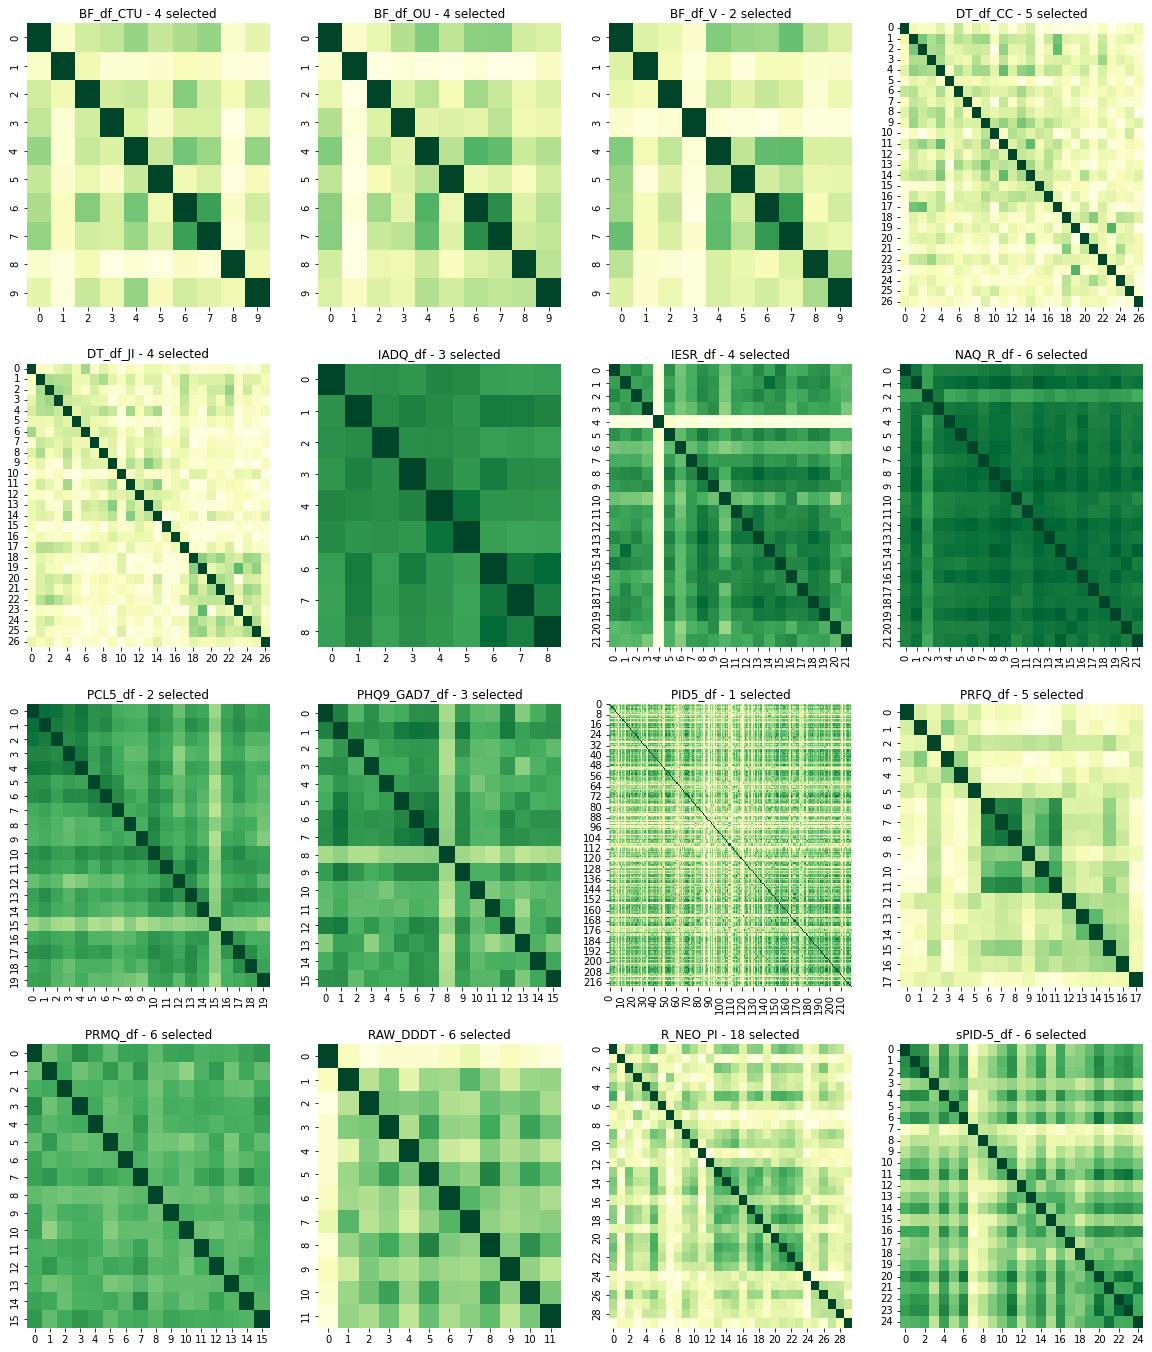

In [4]:
# Compare with correlation matrices
# The greener the higher the correlation
f0, ax0 = plt.subplots(4, 4, figsize = (20, 24))
for n, k in enumerate(data_collection.keys()):
    
    sns.heatmap(pd.DataFrame(data_collection[k][0]).corr().abs(),
                vmin = 0, vmax = 1, cmap = "YlGn",
                cbar = False, ax = ax0[n//4, n%4])
    ax0[n//4, n%4].set_title("{} - {} selected"\
                             .format(k, len(data_collection[k][-2]["Features"])))
plt.show()

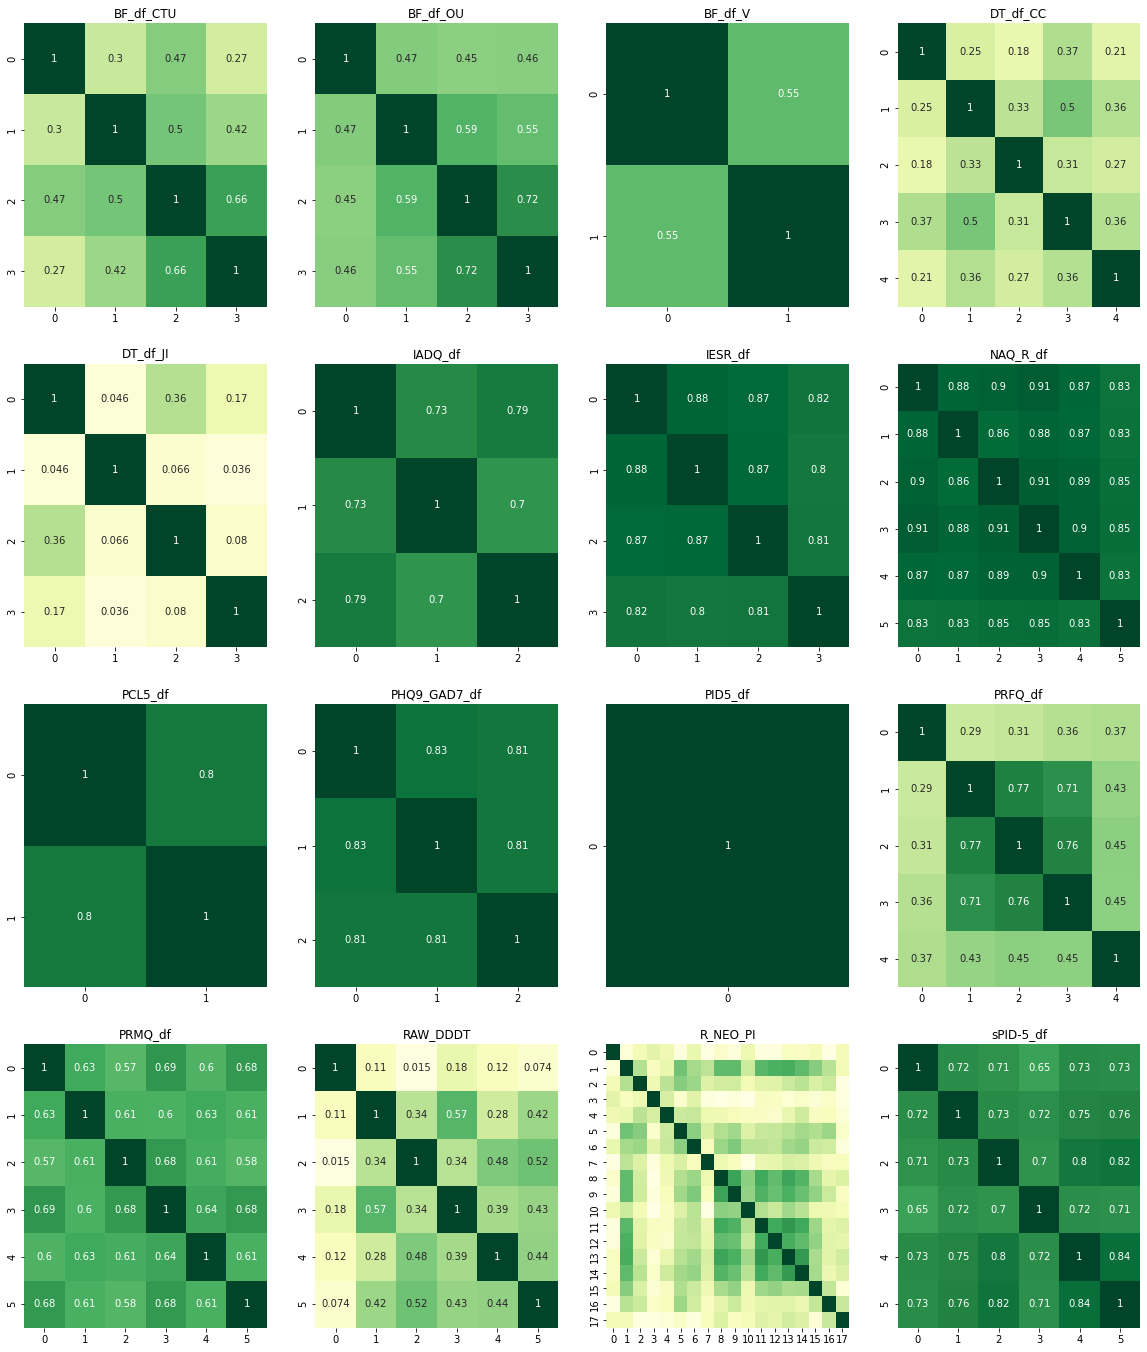

In [5]:
# Correlation matrices of only selected features
# The greener the higher the correlation
f1, ax1 = plt.subplots(4, 4, figsize = (20, 24))
for n, k in enumerate(data_collection.keys()):
    
    feats = data_collection[k][-2]["Features"]
    
    annotation = True if len(feats) < 7 else False
    
    sns.heatmap(pd.DataFrame(data_collection[k][0][:,feats]).corr().abs(),
                vmin = 0, vmax = 1, cmap = "YlGn", annot = annotation,
                cbar = False, ax = ax1[n//4, n%4])

    ax1[n//4, n%4].set_title(k)
    
plt.show()

In [15]:
benchmark = support.lasso_benchmark(data_collection)

In [ ]:
(np.max(benchmark[data_index][1].scores_[1].mean(axis = 0)),
 np.argmax(benchmark[data_index][1].scores_[1].mean(axis = 0)))

In [ ]:
np.max(lasso_benchmark[data_index][1].scores_[1].mean(axis = 0))

In [ ]:
benchmark[data_index][1].scores_[1].max(axis = 0) -\
         (np.std(benchmark[data_index][1].scores_[1].mean(axis = 0), ddof = 1)/\
          np.sqrt(np.size(benchmark[data_index][1].scores_[1].mean(axis = 0))))


 NAQ_R_df

[-0.37957062  0.         -1.2213191  -0.67078297 -0.40569765 -0.47784049]


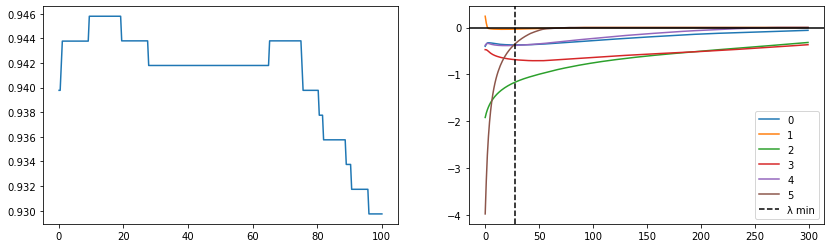

In [7]:
data_index = 7

print("\n", benchmark[data_index][0])
print()
print(benchmark[data_index][1].coef_[0])

lasso_fig, lasso_ax = plt.subplots(1, 2, figsize = (14, 4))

lasso_ax[0].plot(1/(benchmark[data_index][1].Cs_),
                 benchmark[data_index][1].scores_[1].mean(axis = 0))

lasso_ax[1].plot(benchmark[data_index][1].coefs_paths_[1].mean(axis = 0)[:, :-1],
                 label = range(len(benchmark[data_index][1].coef_[0]))) # exclude intercept
lasso_ax[1].axhline(0, color = "black")
lasso_ax[1].axvline(np.argmax(benchmark[data_index][1].scores_[1].mean(axis = 0)),
                    ls = "--", color = "black", label = "λ min")
lasso_ax[1].legend()
plt.show()

In [8]:
benchmark_df = pd.DataFrame(benchmark,
                            columns = ["Dataset", "Algo", "λ min", "λ 1se",
                                       "Zero coeffs at λ min",
                                       "Delta accuracy"]).drop("Algo", axis = 1)
benchmark_df

,Dataset,λ min,λ 1se,Zero coeffs at λ min,Delta accuracy
0,BF_df_CTU,0.100,0.100,0,0.000
1,BF_df_OU,3.107,3.441,0,0.007
2,BF_df_V,0.100,0.100,0,0.000
3,DT_df_CC,0.100,0.100,0,0.000
4,DT_df_JI,1.102,0.100,0,0.000
5,IADQ_df,3.107,0.100,0,0.000
6,IESR_df,1.436,0.100,0,0.009
7,NAQ_R_df,9.455,9.455,1,0.005
8,PCL5_df,0.100,22.820,0,0.000
9,PHQ9_GAD7_df,1.771,0.100,0,0.000


In [ ]:
benchmark_df["Delta accuracy"].describe()[1:]

## Summarize results
***

In [9]:
summary = []
for k, v in data_collection.items():
    
    # Dataset name
    # Sample size
    # Training size
    # Initial number of features
    # Selected features
    # ACCURACY: Full Logit
    # ACCURACY: Logistic Regression
    # ACCURACY: SVC
    # ACCURACY: Random Forest
    # ACCURACY: Neural Network
    # Average accuracy (full logit excluded)
    # Accuracy Standard deviation (full logit excluded)
    # Decreased accuracy (mean) w.r.t. full logit
    
    summary += [[k, len(v[2]) + len(v[3]), len(v[2]),
                 v[0].shape[1], len(v[4]["Features"]),
                 *v[5].tolist(), v[5][1:].mean(), v[5][1:].std(),
                 v[5][1:].mean() - v[5].tolist()[0]]]
    
summary = pd.DataFrame(summary,
                       columns = ["Dataset name", "Sample size", "Training size", "Number of Features",
                                  "Selected Features", "Accuracy - Logit all features",
                                  "Accuracy - Logit", "Accuracy - SVM", "Accuracy - RF",
                                  "Accuracy - MLP", "Avg Acc. on selected features",
                                  "Accuracy Std on selected features", "Acc. diff. wrt Full logit"])

summary = summary.applymap(lambda v: v if isinstance(v, str) else round(v, 3))

summary.sort_values("Accuracy Std on selected features", ascending = False)

,Dataset name,Sample size,Training size,Number of Features,Selected Features,Accuracy - Logit all features,Accuracy - Logit,Accuracy - SVM,Accuracy - RF,Accuracy - MLP,Avg Acc. on selected features,Accuracy Std on selected features,Acc. diff. wrt Full logit
4,DT_df_JI,864,604,27,4,0.662,0.646,0.585,0.592,0.638,0.615,0.031,-0.046
1,BF_df_OU,460,322,10,4,0.833,0.797,0.848,0.841,0.833,0.830,0.023,-0.004
6,IESR_df,358,250,22,4,0.935,0.889,0.926,0.907,0.926,0.912,0.018,-0.023
0,BF_df_CTU,442,309,10,4,0.774,0.812,0.842,0.827,0.812,0.823,0.014,0.049
3,DT_df_CC,482,337,27,5,0.683,0.717,0.717,0.731,0.703,0.717,0.011,0.034
12,PRMQ_df,1404,982,16,6,0.908,0.889,0.910,0.891,0.891,0.895,0.010,-0.012
5,IADQ_df,450,315,9,3,0.852,0.852,0.837,0.837,0.844,0.843,0.007,-0.009
13,RAW_DDDT,986,690,12,6,0.747,0.743,0.757,0.757,0.757,0.753,0.007,0.007
11,PRFQ_df,678,474,18,5,0.936,0.931,0.931,0.922,0.931,0.929,0.005,-0.007
7,NAQ_R_df,712,498,22,6,0.953,0.967,0.977,0.972,0.977,0.973,0.004,0.020


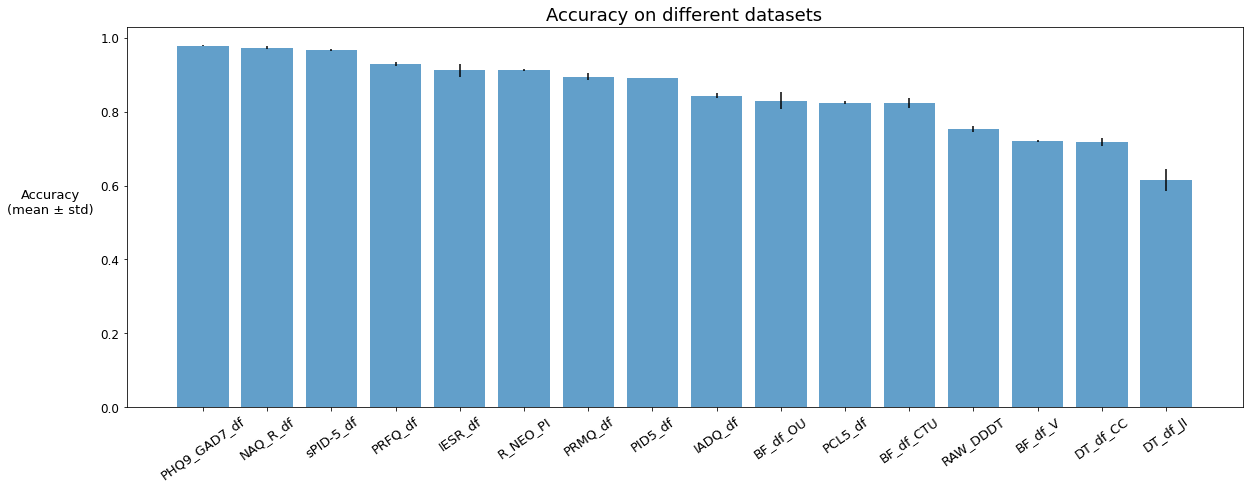

In [10]:
plt.figure(figsize = (20, 7))
plt.bar(x = summary.sort_values("Avg Acc. on selected features",
                                ascending = False)["Dataset name"],
        height = summary.sort_values("Avg Acc. on selected features",
                                     ascending = False)["Avg Acc. on selected features"],
        yerr = summary.sort_values("Avg Acc. on selected features",
                                   ascending = False)["Accuracy Std on selected features"], alpha = .7)
plt.xticks(rotation = 35, fontsize = 13)
plt.yticks(fontsize = 12)
plt.ylabel("Accuracy\n(mean ± std)", fontsize = 13, rotation = 0, labelpad = 50)
plt.title("Accuracy on different datasets", fontsize = 18)
plt.show()

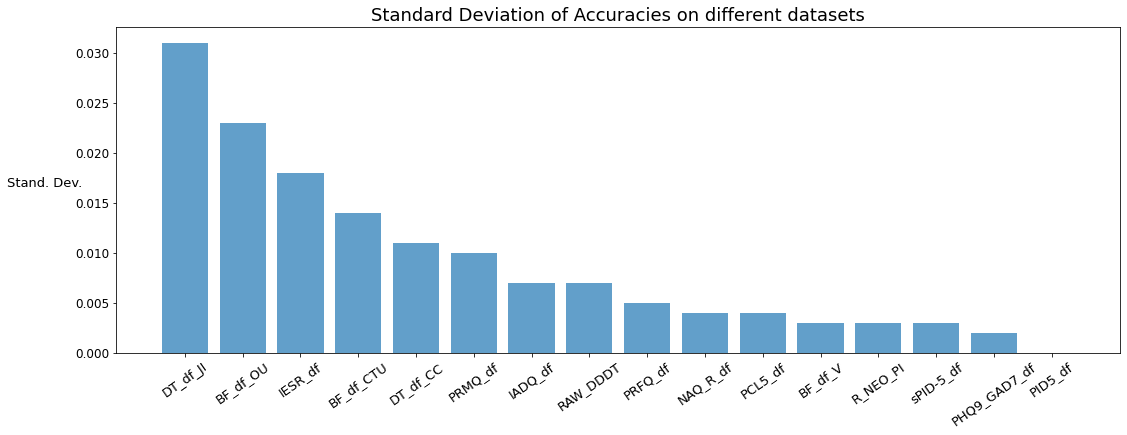

In [11]:
plt.figure(figsize = (18, 6))
plt.bar(x = summary.sort_values("Accuracy Std on selected features",
                                ascending = False)["Dataset name"],
        height = summary.sort_values("Accuracy Std on selected features",
                                     ascending = False)["Accuracy Std on selected features"], alpha = .7)
plt.xticks(rotation = 35, fontsize = 13)
plt.yticks(fontsize = 12)
plt.ylabel("Stand. Dev.", fontsize = 13, rotation = 0, labelpad = 30)
plt.title("Standard Deviation of Accuracies on different datasets", fontsize = 18)
plt.show()

---
---
---